<a href="https://colab.research.google.com/github/ravi161995/Invoice-Extraction-Project/blob/main/notebook/Invoice_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# run in a notebook cell with a leading ! or in terminal
!pip install --upgrade pip
!pip install datasets ultralytics paddlepaddle paddleocr easyocr opencv-python-headless matplotlib pillow tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 31.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 MB 72.2 MB/s  0:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 92.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 767.5/767.5 kB 49.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.7/68.7 MB 62.7 MB/s  0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 107.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 139.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 115.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 78.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 58.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━

In [2]:
import os, json
import numpy as np
import pandas as pd
from tqdm import tqdm
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


Load and Parse CORD Dataset

In [3]:
# Load dataset
ds = load_dataset("naver-clova-ix/cord-v2")
print(ds)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

data/train-00000-of-00004-b4aaeceff1d90e(…):   0%|          | 0.00/490M [00:00<?, ?B/s]

data/train-00001-of-00004-7dbbe248962764(…):   0%|          | 0.00/441M [00:00<?, ?B/s]

data/train-00002-of-00004-688fe1305a55e5(…):   0%|          | 0.00/444M [00:00<?, ?B/s]

data/train-00003-of-00004-2d0cd200555ed7(…):   0%|          | 0.00/456M [00:00<?, ?B/s]

data/validation-00000-of-00001-cc3c5779f(…):   0%|          | 0.00/242M [00:00<?, ?B/s]

data/test-00000-of-00001-9c204eb3f4e1179(…):   0%|          | 0.00/234M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/800 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 800
    })
    validation: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
    test: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
})


In [4]:
def extract_text_labels_from_sample(sample):
    gt = json.loads(sample['ground_truth'])
    gt_parse = gt.get('gt_parse', {})
    texts, labels = [], []

    # Menu items
    if 'menu' in gt_parse:
        for item in gt_parse['menu']:
            if isinstance(item, dict):
                cnt = item.get('cnt','')
                nm  = item.get('nm','')
                price = item.get('price','')
                combined = f"{cnt} {nm} {price}".strip()
                if combined:
                    texts.append(combined)
                    labels.append('menu_item')

    # Subtotal / Total / Service / Tax / etc
    for key in ['sub_total', 'total', 'service_price', 'tax_price', 'etc']:
        val = gt_parse.get(key)
        if val:
            if isinstance(val, dict):
                for k,v in val.items():
                    texts.append(f"{k}: {v}")
                    labels.append(k)
            else:
                texts.append(f"{key}: {val}")
                labels.append(key)

    return texts, labels


In [5]:
sample = ds['train'][0]
texts, labels = extract_text_labels_from_sample(sample)
print(len(texts), texts[:5])
print(labels[:5])

27 ['1 x Nasi Campur Bali 75,000', '1 x Bbk Bengil Nasi 125,000', '1 x MilkShake Starwb 37,000', '1 x Ice Lemon Tea 24,000', '1 x Nasi Ayam Dewata 70,000']
['menu_item', 'menu_item', 'menu_item', 'menu_item', 'menu_item']


Build Dataset Lists

In [6]:
def build_text_label_lists(dataset_split):
    all_texts, all_labels = [], []
    for sample in tqdm(dataset_split):
        t, l = extract_text_labels_from_sample(sample)
        all_texts.extend(t)
        all_labels.extend(l)
    return all_texts, all_labels

train_texts, train_labels = build_text_label_lists(ds['train'])
test_texts, test_labels = build_text_label_lists(ds['test'])
print("Train samples:", len(train_texts))
print("Test samples:", len(test_texts))

100%|██████████| 100/100 [00:04<00:00, 23.01it/s]

Train samples: 5130
Test samples: 619


Clean & Merge Rare Classes

In [7]:
train_df = pd.DataFrame({'text': train_texts, 'label': train_labels})
test_df = pd.DataFrame({'text': test_texts, 'label': test_labels})

# Merge ultra-rare labels
train_df['label'] = train_df['label'].replace({
    'othersvc_price': 'etc',
    'sub_total': 'subtotal_price'
})
test_df['label'] = test_df['label'].replace({
    'othersvc_price': 'etc',
    'sub_total': 'subtotal_price'
})

print(train_df['label'].value_counts())


label
menu_item          1759
total_price         779
subtotal_price      530
cashprice           517
changeprice         500
tax_price           354
menuqty_cnt         228
creditcardprice     121
service_price        98
etc                  69
discount_price       61
emoneyprice          46
menutype_cnt         42
total_etc            26
Name: count, dtype: int64


Encode Labels & Vectorize Text

In [8]:
# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['label'])
y_test = label_encoder.transform(test_df['label'])

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1,2))
X_train = vectorizer.fit_transform(train_df['text'])
X_test = vectorizer.transform(test_df['text'])

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Classes:", label_encoder.classes_)


Train shape: (5130, 3000)
Test shape: (619, 3000)
Classes: ['cashprice' 'changeprice' 'creditcardprice' 'discount_price'
 'emoneyprice' 'etc' 'menu_item' 'menuqty_cnt' 'menutype_cnt'
 'service_price' 'subtotal_price' 'tax_price' 'total_etc' 'total_price']


In [9]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))
print("Class Weights:\n", class_weight_dict)


Class Weights:
 {0: np.float64(0.7087593257806024), 1: np.float64(0.7328571428571429), 2: np.float64(3.0283353010625738), 3: np.float64(6.007025761124122), 4: np.float64(7.96583850931677), 5: np.float64(5.3105590062111805), 6: np.float64(0.208316413546658), 7: np.float64(1.6071428571428572), 8: np.float64(8.724489795918368), 9: np.float64(3.739067055393586), 10: np.float64(0.6913746630727763), 11: np.float64(1.0351089588377724), 12: np.float64(14.093406593406593), 13: np.float64(0.47038327526132406)}


Build a Simple Classifier (using Keras)

In [10]:
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.4),
    layers.Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │     1,536,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 14)             │         3,598 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,671,438 (6.38 MB)

 Trainable params: 1,671,438 (6.38 MB)

 Non-trainable params: 0 (0.00 B)

Prepare Labels & Train Model

In [11]:
y_train_encoded = to_categorical(y_train, num_classes=len(label_encoder.classes_))
y_test_encoded = to_categorical(y_test, num_classes=len(label_encoder.classes_))

history = model.fit(
    X_train.toarray(), y_train_encoded,
    validation_data=(X_test.toarray(), y_test_encoded),
    epochs=20,
    batch_size=32,
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.4803 - loss: 2.7204 - val_accuracy: 1.0000 - val_loss: 0.6443
Epoch 2/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9882 - loss: 0.5390 - val_accuracy: 1.0000 - val_loss: 0.4234
Epoch 3/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9973 - loss: 0.3696 - val_accuracy: 1.0000 - val_loss: 0.3135
Epoch 4/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 0.2969 - val_accuracy: 1.0000 - val_loss: 0.2639
Epoch 5/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 0.2577 - val_accuracy: 1.0000 - val_loss: 0.2353
Epoch 6/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 0.2307 - val_accuracy: 1.0000 - val_loss: 0.2171
Epoch 7/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9996 - loss: 0.2183 - val_accuracy: 1.0000 - val_loss: 0.1958
Epoch 8/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9993 - loss: 0.2040 - val_accuracy: 1

Evaluate Model

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

Classification Report:

                 precision    recall  f1-score   support

      cashprice       1.00      1.00      1.00        67
    changeprice       1.00      1.00      1.00        56
creditcardprice       1.00      1.00      1.00        16
 discount_price       1.00      1.00      1.00         6
    emoneyprice       1.00      1.00      1.00         1
            etc       1.00      1.00      1.00         7
      menu_item       1.00      1.00      1.00       212
    menuqty_cnt       1.00      1.00      1.00        29
   menutype_cnt       1.00      1.00      1.00         7
  service_price       1.00      1.00      1.00        12
 subtotal_price       1.00      1.00      1.00        65
      tax_price       1.00      1.00      1.00        43
      total_etc       1.00      1.00      1.00         3
    total_price       1.00      1.00      1.00        95

       accuracy                           1.00       619
      macro avg      

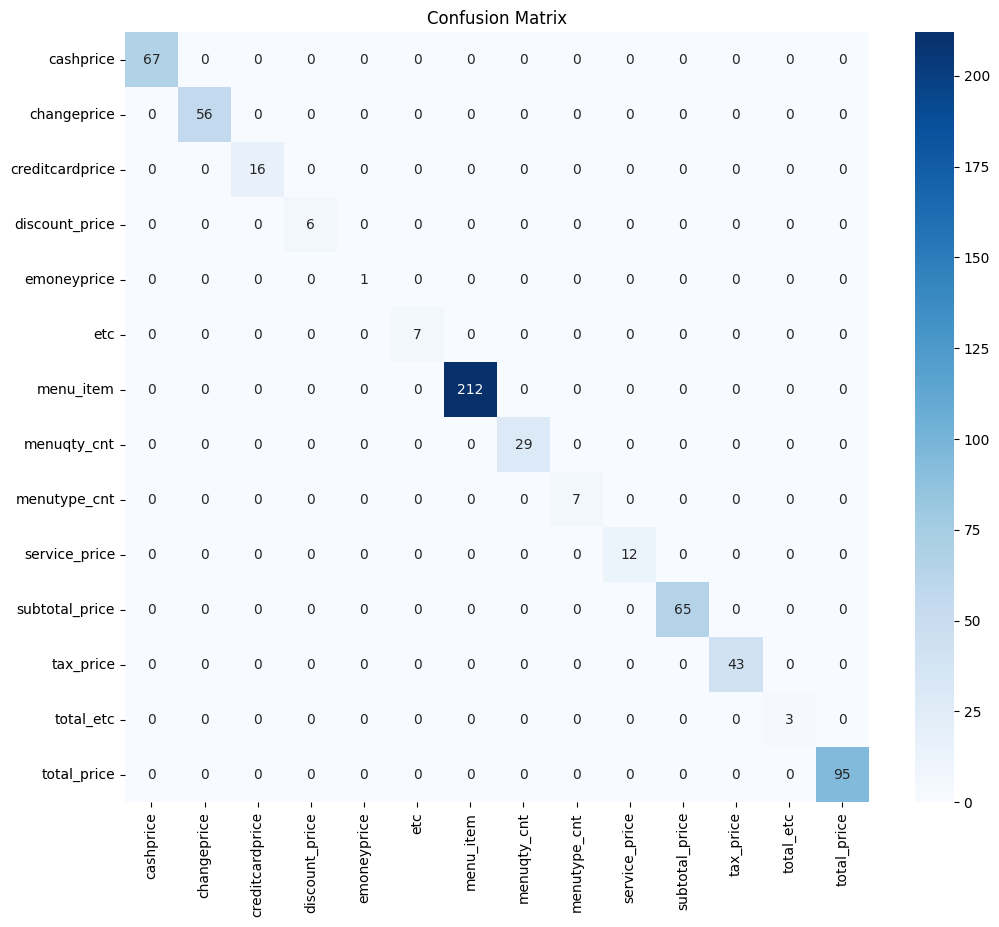

In [12]:
y_pred = np.argmax(model.predict(X_test.toarray()), axis=1)

print("\nClassification Report:\n")
print(classification_report(
    y_test, y_pred, target_names=label_encoder.classes_
))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.show()


In [13]:
import joblib

model.save("invoice_classifier.h5")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")

print("✅ Model and artifacts saved!")


✅ Model and artifacts saved!
